# Riskfolio-Lib Tutorial: 
<br>__[Financionerioncios](https://financioneroncios.wordpress.com)__
<br>__[Orenji](https://www.orenj-i.net)__
<br>__[Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/)__
<br>__[Dany Cajas](https://www.linkedin.com/in/dany-cajas/)__
<a href='https://ko-fi.com/B0B833SXD' target='_blank'><img height='36' style='border:0px;height:36px;' src='https://cdn.ko-fi.com/cdn/kofi1.png?v=2' border='0' alt='Buy Me a Coffee at ko-fi.com' /></a> 

## Part XV: Mean [Entropic Value at Risk (EVaR)](https://en.wikipedia.org/wiki/Entropic_value_at_risk) Optimization

## 1. Downloading the data:

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")

yf.pdr_override()
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2016-01-01'
end = '2019-12-30'

# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'NBL', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'DHR',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%***********************]  24 of 24 completed


In [2]:
# Calculating returns

Y = data[assets].pct_change().dropna()

display(Y.head())

,APA,BAX,BMY,CMCSA,CNP,CPB,DE,DHR,HPQ,JCI,...,MSFT,NBL,NI,PCAR,PSA,SEE,TGT,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,-2.0257%,0.4035%,1.9693%,0.0180%,0.9305%,0.3678%,0.5783%,0.1854%,0.9483%,-1.1953%,...,0.4562%,0.4478%,1.5881%,0.0212%,2.8236%,0.9758%,1.7539%,0.2410%,1.3734%,-1.0857%
2016-01-06,-11.4863%,0.2412%,-1.7557%,-0.7727%,-1.2473%,-0.1736%,-1.1239%,-1.1649%,-3.5867%,-0.9551%,...,-1.8165%,-5.8247%,0.5547%,0.0212%,0.1592%,-1.5646%,-1.0155%,-3.0048%,-0.9034%,-2.9145%
2016-01-07,-5.1389%,-1.6573%,-2.7699%,-1.1047%,-1.9769%,-1.2207%,-0.8855%,-2.5666%,-4.6059%,-2.5394%,...,-3.4783%,-2.5245%,-2.2066%,-3.0309%,-1.0410%,-3.1557%,-0.2700%,-2.0570%,-0.5492%,-3.0019%
2016-01-08,0.2737%,-1.6037%,-2.5425%,0.1099%,-0.2241%,0.5707%,-1.6402%,0.0565%,-1.7642%,-0.1649%,...,0.3067%,-0.1942%,-0.1538%,-1.1366%,-0.7308%,-0.1448%,-3.3839%,-1.1387%,-0.9719%,-1.1254%
2016-01-11,-4.3384%,-1.6851%,-1.0215%,0.0915%,-1.1791%,0.5674%,0.5287%,-0.0565%,0.6616%,0.0330%,...,-0.0573%,-5.9682%,1.6435%,0.0000%,0.9869%,-0.1450%,1.4570%,-0.4607%,0.5800%,-1.9918%


## 2. Estimating Mean EVaR Portfolios

### 2.1 Calculating the portfolio that maximizes Return/EVaR ratio.

The Entropic Value at Risk which is a new risk measure introduced by Ahmadi-Javid (2012) and is defined as:

$$
\text{EVaR}_{\alpha}(X) = \inf_{z>0} \left \{z\log \left ( \frac{1}{\alpha} M_{X} (\frac{1}{z}) \right ) \right \}
$$

Where $M_{X} (t) = \text{E} [e^{tX}]$ is the moment generating function and $\alpha \in [0,1]$ is the significance level.
    
In a similar way than Markowitz model, the mean EVaR model can be expressed as one of the following problems:

$$
\begin{aligned}
& \min_{w,\, z} & & \mu w - \lambda \text{EVaR}_{\alpha}(r w)\\
& & & 1^{T}w = 0 \\
& & & w \geq 0 \\
\end{aligned}
$$

$$
\begin{aligned}
& \max_{w,\, z} & & \frac{\mu w - r_{f}}{\lambda \text{EVaR}_{\alpha}(r w)}\\
& & & 1^{T}w = 0 \\
& & & w \geq 0 \\
\end{aligned}
$$

$$
\begin{aligned}
& \min_{w,\, z} & & \text{EVaR}_{\alpha}(r w)\\
& & & 1^{T}w = 0 \\
& & & w \geq 0 \\
\end{aligned}
$$

Where $z$ is the factor of EVaR, $w$ are the weights of assets, $\mu$ is the mean vector, $\lambda$ is the risk aversion factor, $r$ is the returns matrix and $r_{f}$ the risk free rate.

In [3]:
import riskfolio.Portfolio as pf

# Building the portfolio object
port = pf.Portfolio(returns=Y)

# Calculating optimum portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

port.alpha = 0.05 # Significance level for CVaR, EVaR y CDaR 
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'EVaR' # Risk measure used, this time will be EVaR
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,APA,BAX,BMY,CMCSA,CNP,CPB,DE,DHR,HPQ,JCI,...,MSFT,NBL,NI,PCAR,PSA,SEE,TGT,TXT,VZ,ZION
weights,0.0000%,0.0000%,0.0000%,0.0000%,1.5771%,0.0000%,0.0000%,52.2753%,0.0000%,0.0000%,...,7.5233%,0.0000%,2.7980%,0.0000%,0.0000%,0.0000%,13.8072%,0.0000%,0.0000%,0.0000%


### 2.2 Plotting portfolio composition

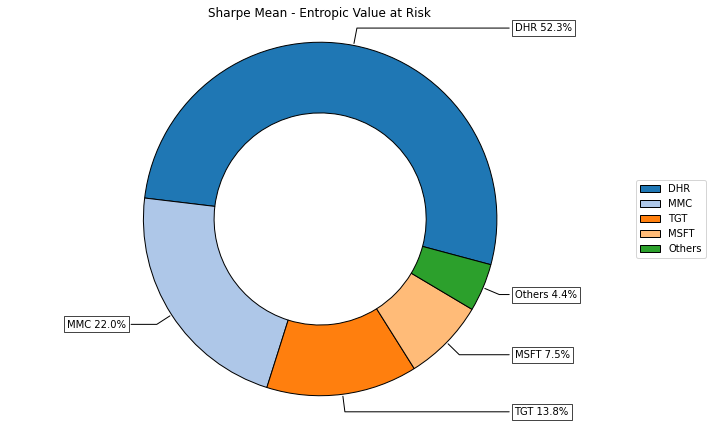

In [4]:
import riskfolio.PlotFunctions as plf

# Plotting the composition of the portfolio

ax = plf.plot_pie(w=w, title='Sharpe Mean - Entropic Value at Risk', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)

### 2.3 Calculate efficient frontier

In [5]:
points = 40 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,APA,BAX,BMY,CMCSA,CNP,CPB,DE,DHR,HPQ,JCI,...,MSFT,NBL,NI,PCAR,PSA,SEE,TGT,TXT,VZ,ZION
0,0.0000%,0.0000%,10.1169%,1.0878%,6.1330%,12.0723%,0.0000%,0.0000%,0.0000%,0.0000%,...,0.0000%,0.0000%,1.1602%,0.0000%,22.5145%,0.4457%,14.2493%,0.0000%,1.0375%,0.0000%
1,0.0000%,2.8675%,6.9163%,0.0000%,14.1262%,10.3280%,0.0000%,2.7922%,0.0000%,0.0000%,...,0.0000%,0.0000%,0.0891%,0.0000%,14.2588%,0.0000%,15.2791%,0.0000%,0.9855%,0.0000%
2,0.0000%,0.9788%,4.6687%,0.0000%,15.0966%,9.5280%,0.0000%,8.4648%,0.0000%,0.0000%,...,0.0000%,0.0000%,0.9150%,0.0000%,11.2112%,0.0000%,15.6639%,0.0000%,0.0000%,0.0000%
3,0.0000%,0.0000%,2.5190%,0.0000%,15.7700%,9.0795%,0.0000%,12.8289%,0.0000%,0.0000%,...,0.0000%,0.0000%,1.5547%,0.0000%,8.1718%,0.0000%,16.0127%,0.0000%,0.0000%,0.0000%
4,0.0000%,0.0000%,0.4984%,0.0000%,16.6613%,8.8767%,0.0000%,16.3525%,0.0000%,0.0000%,...,0.0000%,0.0000%,2.0250%,0.0000%,5.1967%,0.0000%,16.4017%,0.0000%,0.0000%,0.0000%


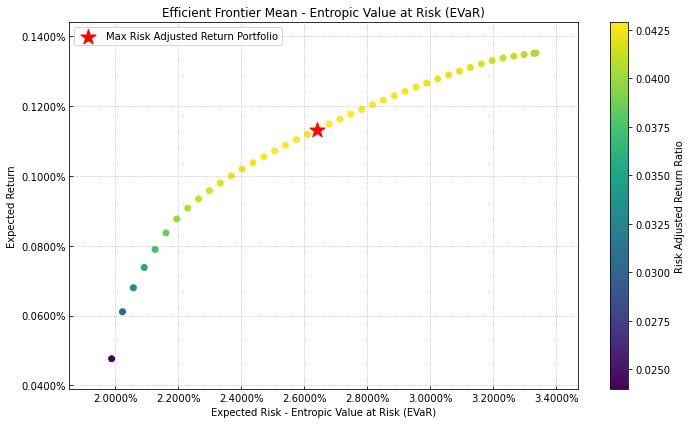

In [6]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = plf.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                       rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                       marker='*', s=16, c='r', height=6, width=10, ax=None)

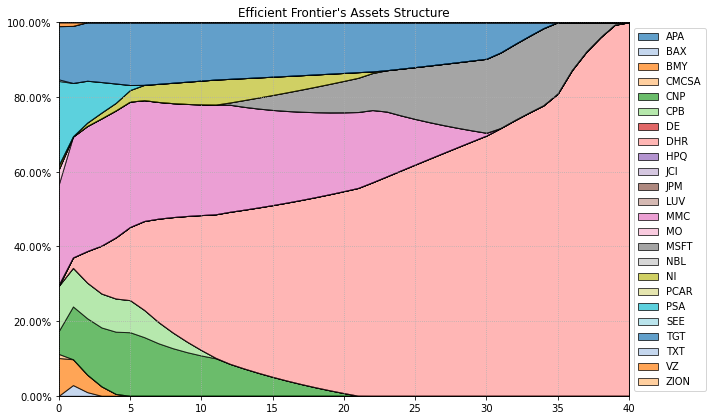

In [7]:
# Plotting efficient frontier composition

ax = plf.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

## 3. Estimating Risk Parity Portfolios for EVaR

### 3.1 Calculating the risk parity portfolio for EVaR.

The risk parity portfolio for the EVaR risk measure is the solution of the problem:

$$
\begin{aligned}
& \min_{w,\, z} & & \text{EVaR}_{\alpha}(r w) - b \ln(w)\\
& & & 1^{T}w = 0 \\
& & & w \geq 0 \\
\end{aligned}
$$

Where $w$ are the weights of assets, $b$ is the vector of constraints, by default is a vector of 1/(number of assets).

In [11]:
b = None # Risk contribution constraints vector

w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

display(w_rp.T)

,APA,BAX,BMY,CMCSA,CNP,CPB,DE,DHR,HPQ,JCI,...,MSFT,NBL,NI,PCAR,PSA,SEE,TGT,TXT,VZ,ZION
weights,2.8376%,3.6350%,4.8807%,3.6707%,5.7563%,7.8805%,3.0709%,3.5032%,2.8132%,3.4300%,...,3.2678%,2.8731%,6.6583%,3.3500%,6.3401%,3.7448%,5.8426%,3.2396%,4.2968%,2.9082%


### 3.2 Plotting portfolio composition

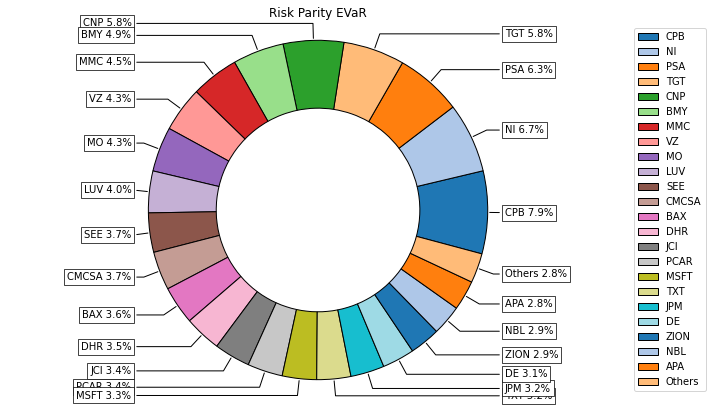

In [9]:
ax = plf.plot_pie(w=w_rp, title='Risk Parity EVaR', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)

### 3.3 Plotting Risk Composition

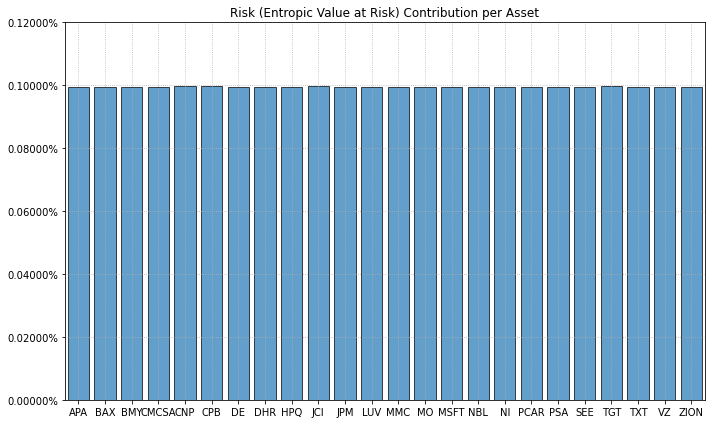

In [10]:
ax = plf.plot_risk_con(w_rp, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.05,
                       color="tab:blue", height=6, width=10, ax=None)